In [322]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2
import torch
import torchvision.transforms as transforms

from gel_tools.band_detection import watershed_seg
from segmentation.unet import UNet
from segmentation.evaluation.basic_eval import evaluate
from segmentation.helper_functions.data_functions import prep_dataloader

In [9]:
selected_file = "C:/2022_Summer_Intern/Gel_Images_UNet_Test/Models/PC_Gel_Nathan_Q1+Q2+selected_2022_07_28_16;42;07/segmentation_images/epoch1_mask_pred.npy"

In [101]:
selected_file = "C:/Users/s2137314/Downloads/epoch160_mask_pred.npy"

In [347]:
selected_file = 'C:/Users/s2137314/Downloads/epoch172_mask_pred.npy'

In [348]:
# mask_pred = cv2.imread()  # H, W, C

In [349]:


data = np.load(selected_file)
height = int(data.shape[0])
width = int(data.shape[1])
print(data.shape)

(538, 117, 2)


# Threshold Comparisons

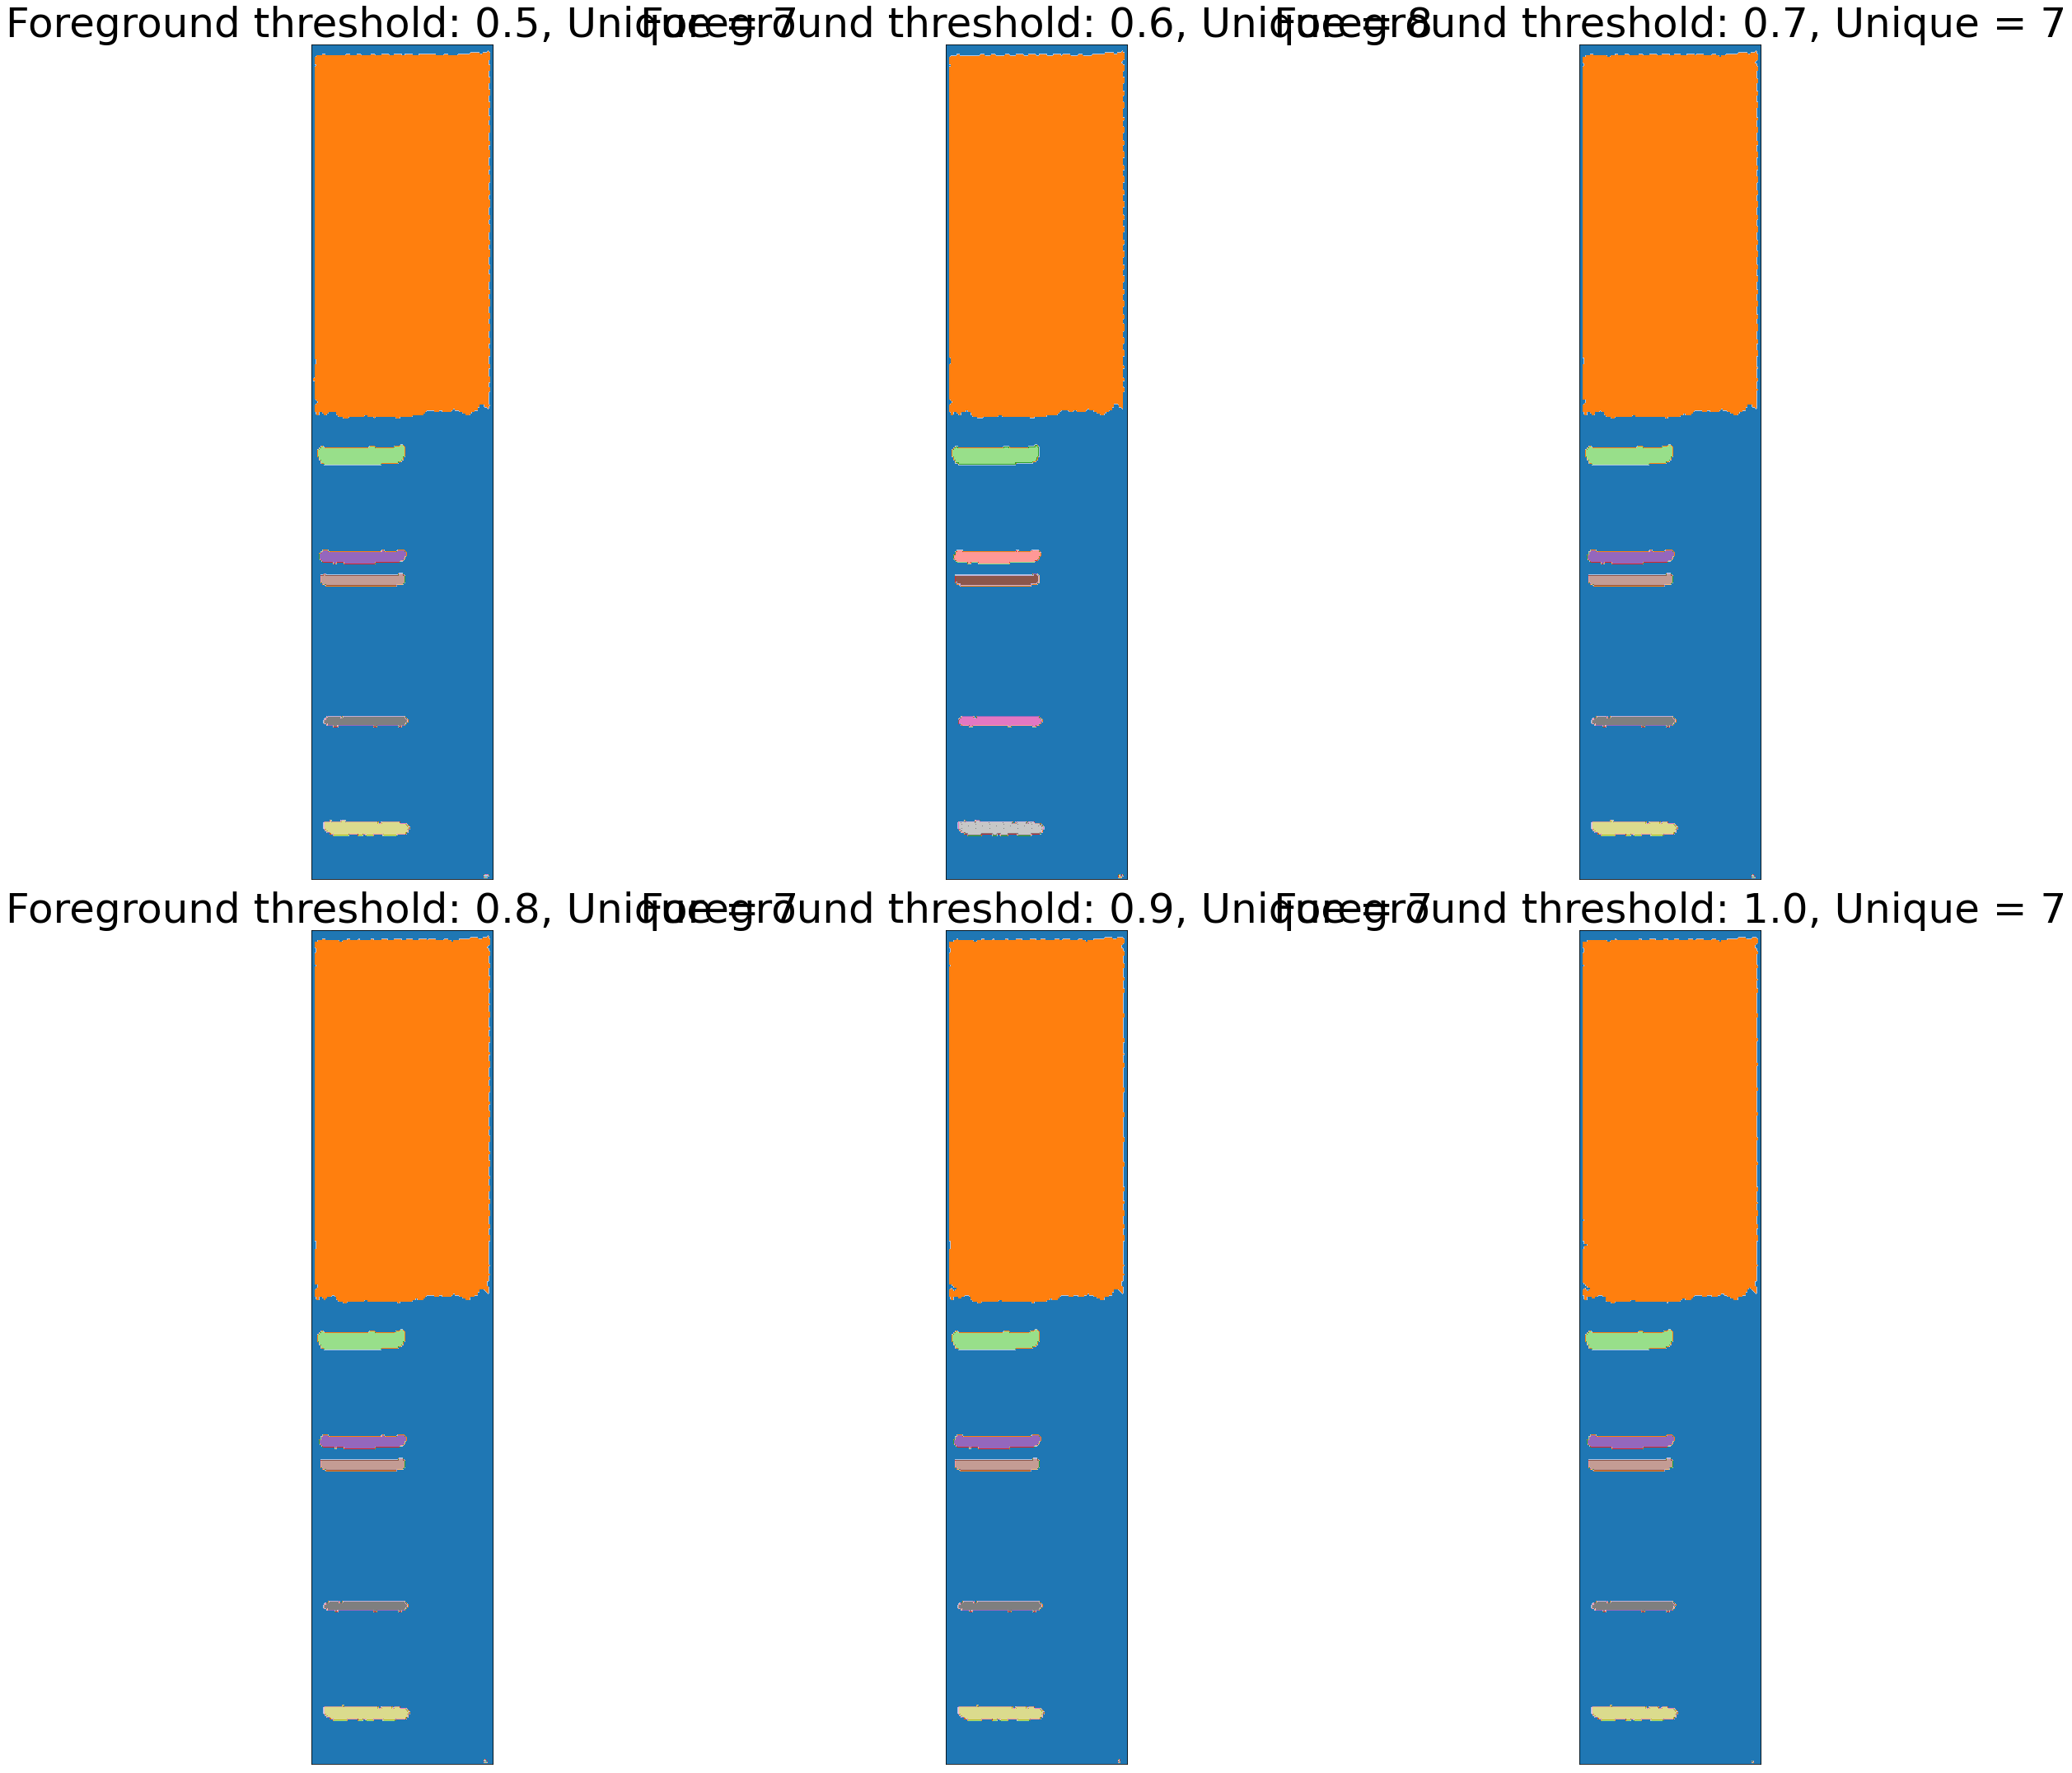

In [350]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(50, 30))
for i in range(5, 11):  # 5 - 10
    threshold = i / 10
    thresholded = np.zeros((height, width))
    for row in range(height):
        for column in range(width):
            if data[row][column][0] < (1-threshold) and data[row][column][1] > threshold:
                thresholded[row][column] = 1
    # watershed
    separated = watershed_seg(thresholded, 0.5, 0.5)
    unique = np.unique(separated)[-1]
    
    axs[(i-5)//3][(i-5)%3].imshow(separated, cmap='tab20')
    axs[(i-5)//3][(i-5)%3].set_title(f'Foreground threshold: {threshold}, Unique = {unique}', fontsize=50)
    
    plt.tight_layout()
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])  # remove ticks
    

# Decided Threshold: 0.8

In [351]:
threshold = 0.8
thresholded = np.zeros((height, width))
for row in range(height):
    for column in range(width):
        if data[row][column][0] < (1-threshold) and data[row][column][1] > threshold:
            thresholded[row][column] = 1
# watershed
separated = watershed_seg(thresholded, 0.5, 0.5)
unique = np.unique(separated)

In [352]:
# Get coordinates for each unique band
# create array of intensities
volume_labels = np.empty((len(unique)), float)

In [353]:
selected_image = "C:/2022_Summer_Intern/Gel_Images_UNet_Test/Images_all_nathan+selected/pBR332BstNI_DNAladder.png"

In [354]:
image = imageio.imread(selected_image)  # 0-255, H, W

C:\Users\s2137314\Anaconda3\envs\gel_env\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  """Entry point for launching an IPython kernel.


In [355]:
image.shape

(538, 117, 4)

In [356]:
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # 1 channel

In [357]:
image = image.astype(np.float32) / (255 - 0)  # normalized between 0 and 1

In [358]:
for h in range(height):
    for w in range(width):
        volume_labels[separated[h][w]] += image[h][w]  # index = label, value += intensity(between 0 and 1)

In [359]:
print(volume_labels)

[ 9333.23153773 25965.           573.27451104   387.88235423
  1316.10098135   254.34510159  1121.32843509   -45.        ]


<BarContainer object of 7 artists>

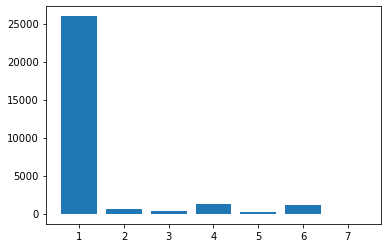

In [373]:
plt.bar(range(1, len(volume_labels)), volume_labels[1:])

[0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 0 0 0]
[9.37123154e+03 2.59750000e+04 5.73274511e+02 3.87882354e+02
 3.53850981e+02 2.54345102e+02 1.59078435e+02 3.00000000e+00]


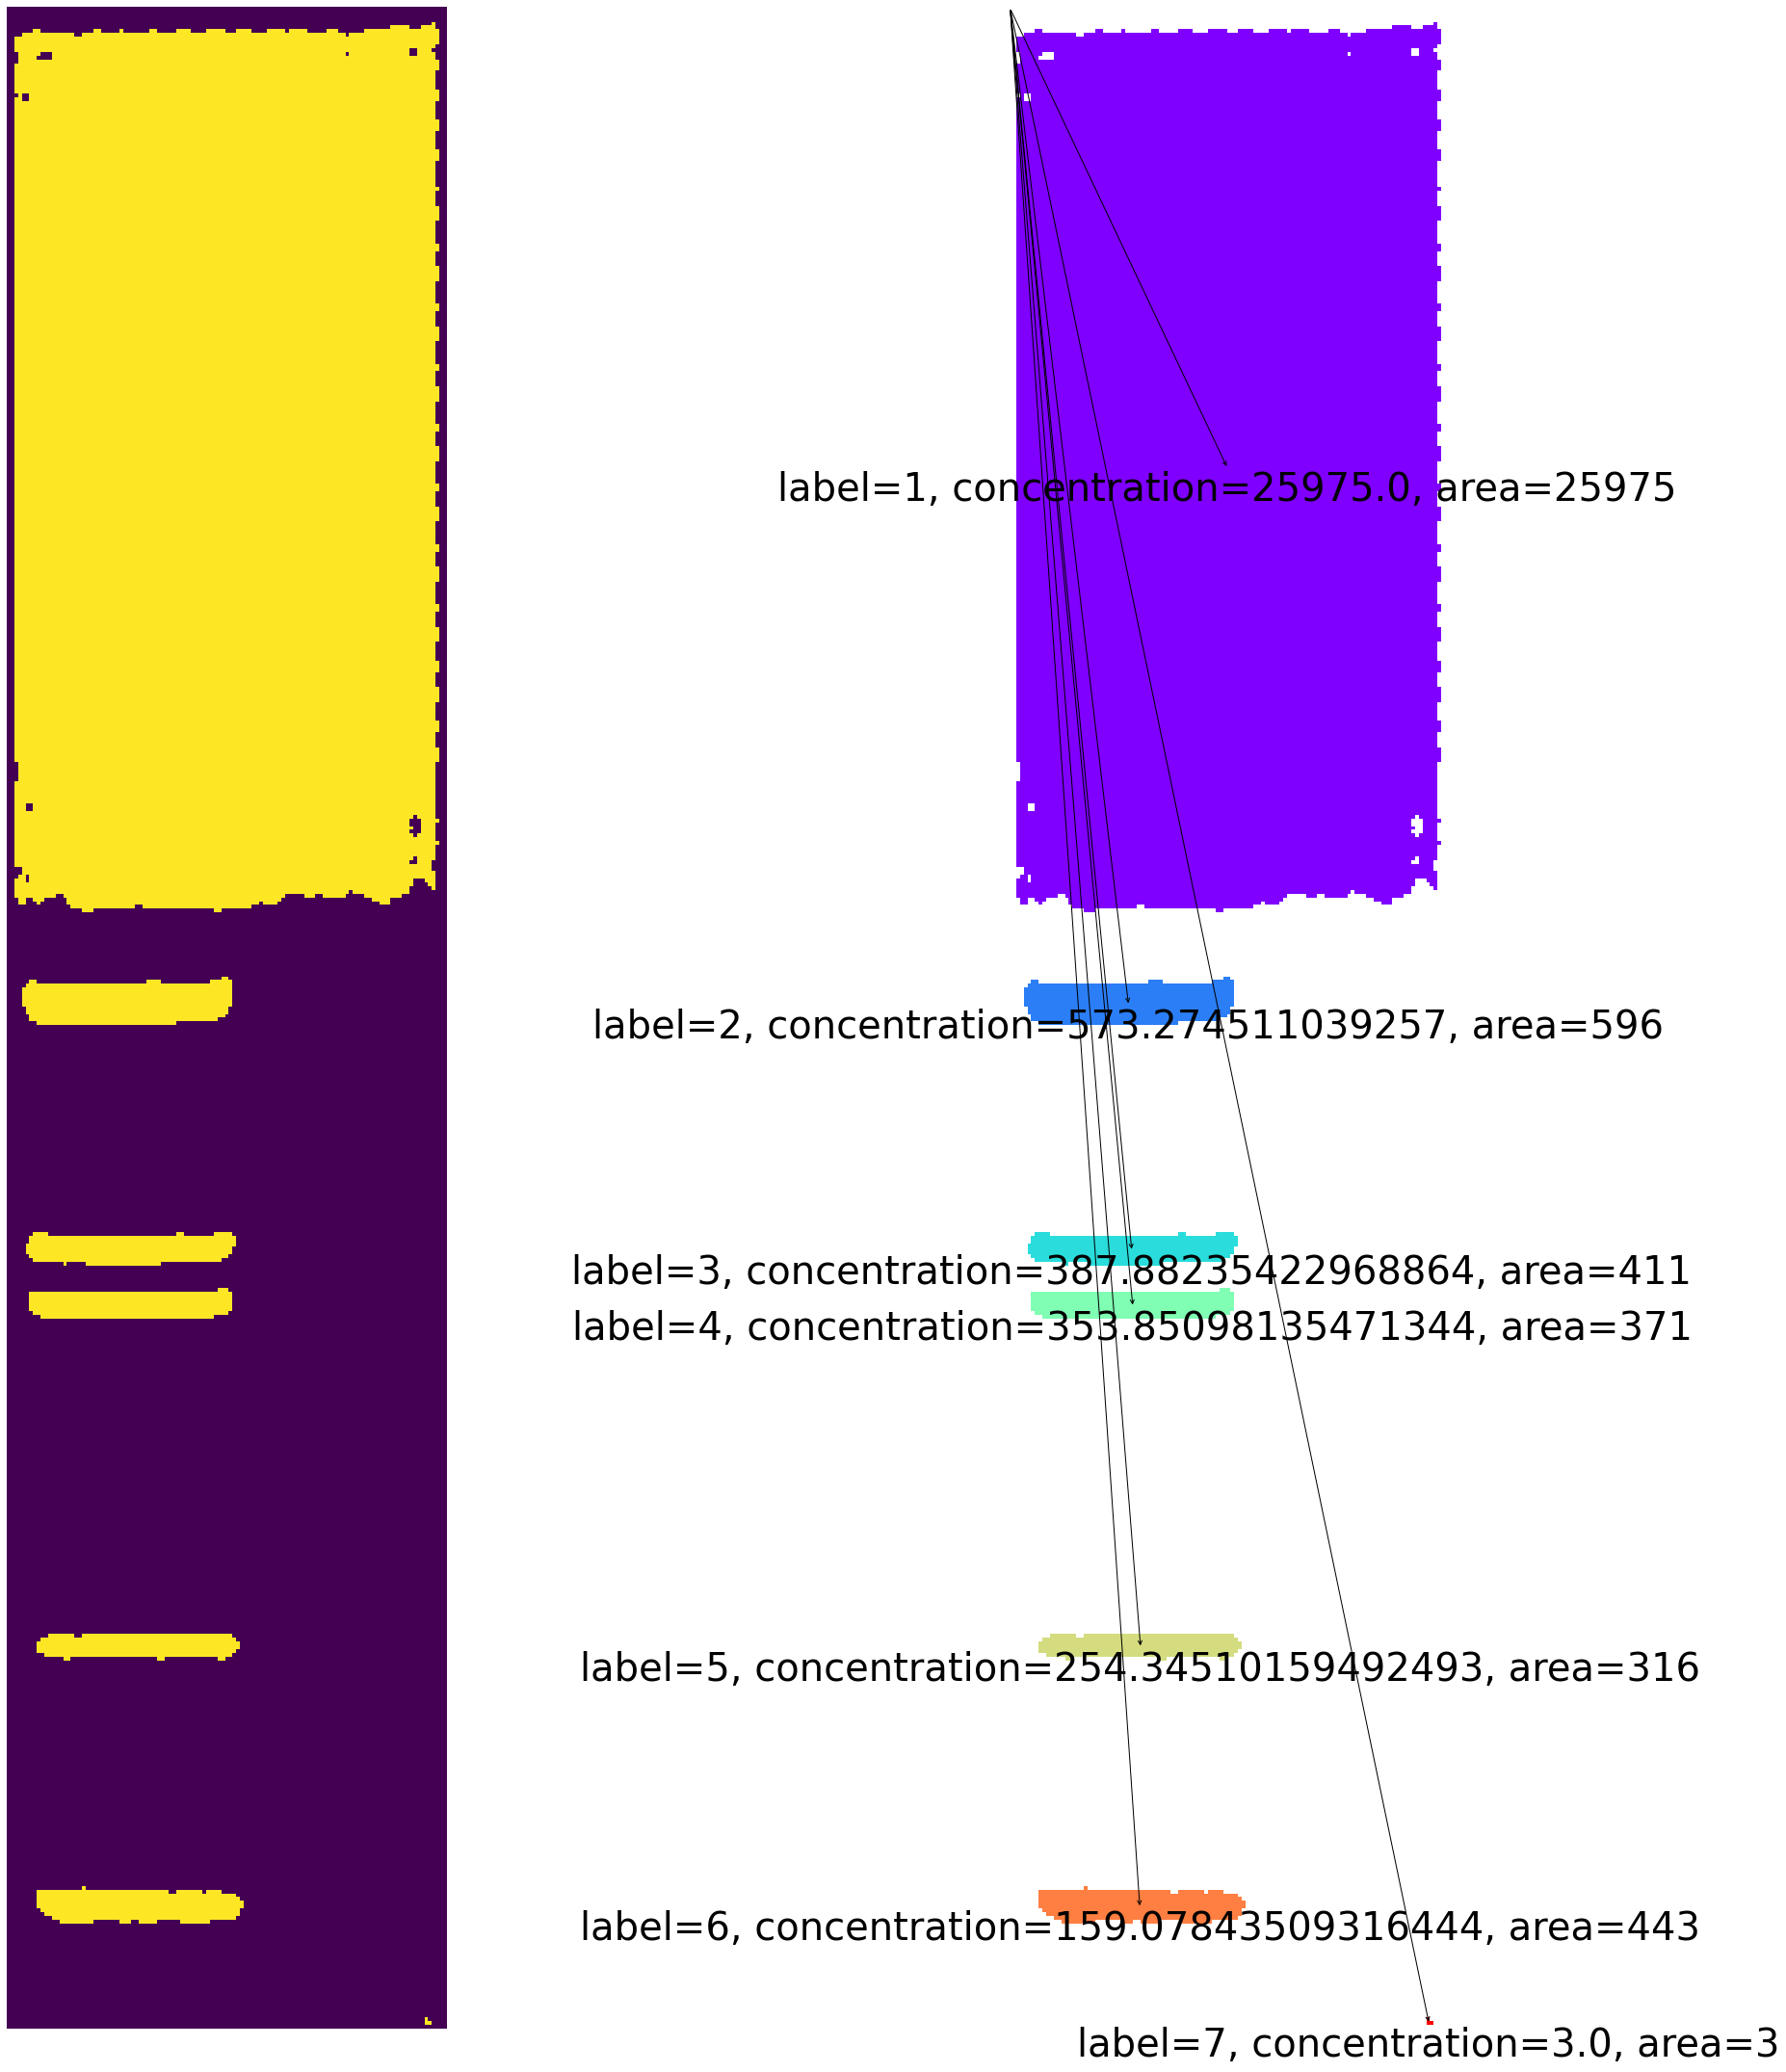

In [386]:
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt

# use a boolean condition to find where pixel values are > 0.75
blobs = thresholded == 1

# label connected regions that satisfy this condition
labels, nlabels = ndimage.label(blobs, structure=[[1,1,1],[1,1,1],[1,1,1]])


# find their centres of mass. in this case I'm weighting by the pixel values in
# `img`, but you could also pass the boolean values in `blobs` to compute the
# unweighted centroids.
r, c = np.vstack(ndimage.center_of_mass(thresholded, labels, np.arange(nlabels) + 1)).T

# find their distances from the top-left corner
d = np.sqrt(r*r + c*c)


# Get coordinates for each unique band
# create array of intensities
volume_labels = np.zeros((len(unique)), float)
area_labels = np.zeros((len(unique)), int)
print(volume_labels)
print(area_labels)

for h in range(height):
    for w in range(width):
        volume_labels[labels[h][w]] += image[h][w]  # index = label, value += intensity(between 0 and 1)
        area_labels[labels[h][w]] += 1
print(volume_labels)

# plot
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(30, 30))
ax[0].imshow(thresholded)
ax[1].imshow(np.ma.masked_array(labels, ~blobs), cmap=plt.cm.rainbow)
for ri, ci, di in zip(r, c, d):
    ax[1].annotate('', xy=(0, 0), xytext=(ci, ri),
                   arrowprops={'arrowstyle':'<-', 'shrinkA':0})
    label = int(labels[int(ri)][int(ci)])
    ax[1].annotate(f'label={label}, concentration={volume_labels[label]}, area={area_labels[label]}', xy=(ci, ri),  xytext=(0, -5),
               textcoords='offset points', ha='center', va='top',
               fontsize=40)
for aa in ax.flat:
    aa.set_axis_off()
fig.tight_layout()
plt.show()

In [394]:
measured_ratios = []
real_ratios = []
real_volumes = [426, 243, 213, 88, 28]
measured_volumes = volume_labels[2:-1]
base_value_real = 28
base_value_measured = 159

for r, m in zip(real_volumes, measured_volumes):
    real_ratios.append(r/base_value_real)
    measured_ratios.append(m/base_value_measured)
print(real_ratios)
print(measured_ratios)

426 573.274511039257 28
243 387.88235422968864 28
213 353.85098135471344 28
88 254.34510159492493 28
28 159.07843509316444 28
[15.214285714285714, 8.678571428571429, 7.607142857142857, 3.142857142857143, 1.0]
[3.6055000694292896, 2.4395116618219412, 2.2254778701554305, 1.5996547270121064, 1.0004933024727323]


1.0

# Test on model gel image

In [438]:
original_image = imageio.imread("C:/Users/s2137314/Downloads/1kb_DNAladder_edited.png")
n_channels = 1

C:\Users\s2137314\Anaconda3\envs\gel_env\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  """Entry point for launching an IPython kernel.


In [439]:
# Converting to desired number of channels
if n_channels == 1:  # Target input: 1 channel
    if original_image.shape[-1] == 3:  # Actual input: 3 channels
        original_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
    elif original_image.shape[-1] == 4: # Actual input: 4 channels
        original_image = cv2.cvtColor(original_image, cv2.COLOR_RGBA2GRAY)
    # No change required for already grayscale images
elif n_channels == 3:  # Target input: 3 channels
    if original_image.shaoe[-1] == 4:  # Actual input: 4 channels
        original_image = cv2.cvtColor(original_image, cv2.COLOR_RGBA2RGB)
    elif original_image.shape[-1] != 3:  # Actual input: 1 channels
        original_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2RGB)


# Normalizing image
if original_image.dtype == 'uint8':
    max_val = 255
elif original_image.dtype == 'uint16':
    max_val = 65535
original_image = original_image.astype(np.float32) / (max_val - 0)

standard_image_transform = transforms.Compose([transforms.ToTensor()])
original_image_tensor = standard_image_transform(original_image)

In [440]:
original_image_tensor = torch.unsqueeze(original_image_tensor, dim=0)

In [441]:
print(original_image_tensor.shape)

torch.Size([1, 1, 463, 66])


In [442]:
net = UNet(n_channels=1, n_classes=2, bilinear=False)
net.train()
modelweights = torch.load(f="C:/Users/s2137314/Downloads/checkpoint_epoch170.pth", map_location=torch.device("cpu"))
net.load_state_dict(state_dict = modelweights)

<All keys matched successfully>

In [443]:
with torch.no_grad():
    # predict the mask
    mask_pred = net(original_image_tensor)

In [444]:
mask_pred.squeeze()

tensor([[[ 2.9143,  3.5979,  3.7856,  ...,  3.9085,  3.6359,  3.1404],
         [ 3.4225,  3.7852,  3.6054,  ...,  4.1155,  3.6904,  3.2801],
         [ 3.7753,  4.2198,  3.9272,  ...,  4.2812,  3.7376,  3.3248],
         ...,
         [ 3.3238,  3.0025,  3.1812,  ...,  3.1186,  2.6705,  2.9631],
         [ 3.0888,  3.4535,  3.3567,  ...,  3.6450,  3.5544,  3.6431],
         [ 2.6720,  3.5954,  3.4853,  ...,  3.8961,  3.7425,  3.2102]],

        [[-3.2108, -3.9381, -4.3274,  ..., -4.3450, -4.1411, -3.5453],
         [-3.7691, -4.2058, -4.1370,  ..., -4.5824, -4.1038, -3.6359],
         [-4.1702, -4.5206, -4.4280,  ..., -4.6471, -4.1361, -3.7693],
         ...,
         [-3.7594, -3.5268, -3.5490,  ..., -3.5721, -3.0299, -3.4609],
         [-3.4829, -3.9653, -3.8337,  ..., -4.1887, -4.0130, -4.1638],
         [-3.0374, -3.9735, -3.9268,  ..., -4.3644, -4.1160, -3.6162]]])

In [445]:
mask_pred_array = np.transpose(mask_pred.detach().squeeze().cpu().numpy(), (1, 2, 0))  # CHW to HWC

In [446]:
mask_pred_array.shape

(463, 66, 2)

In [447]:
height, width = mask_pred_array.shape[0], mask_pred_array.shape[1]

In [448]:
print(range(height)[-1])

462


In [449]:
threshold = 0.8
thresholded = np.zeros((height, width))
for row in range(height):
    for column in range(width):
        if mask_pred_array[row][column][0] < (1-threshold) and mask_pred_array[row][column][1] > threshold:
            thresholded[row][column] = 1
# watershed
separated = watershed_seg(thresholded, 0.5, 0.5)
unique = np.unique(separated)

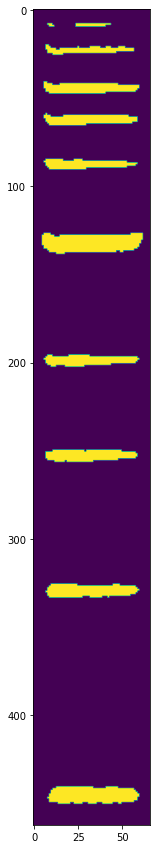

In [450]:
plt.figure(figsize=(10,15))
plt.imshow(thresholded)

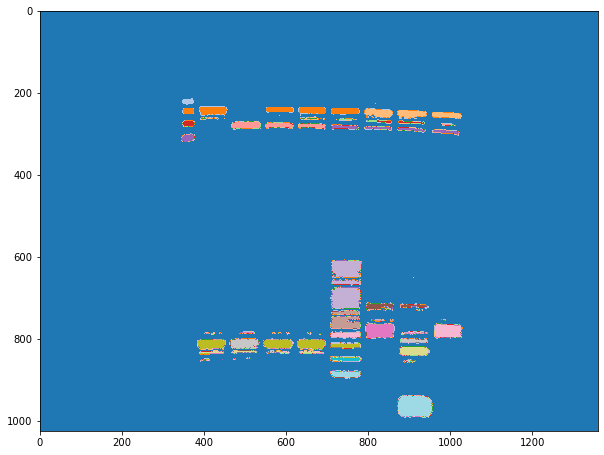

In [409]:
plt.figure(figsize=(10,15))
plt.imshow(separated, cmap='tab20')

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0 0 0 0 0 0 0 0 0 0 0 0]
[6.98926291e+03 4.84313732e+00 2.93333338e+01 1.23764708e+02
 2.17537259e+02 1.94556867e+02 1.55262749e+02 5.09462747e+02
 2.00078435e+02 1.77886279e+02 1.78701967e+02 1.64482356e+02]


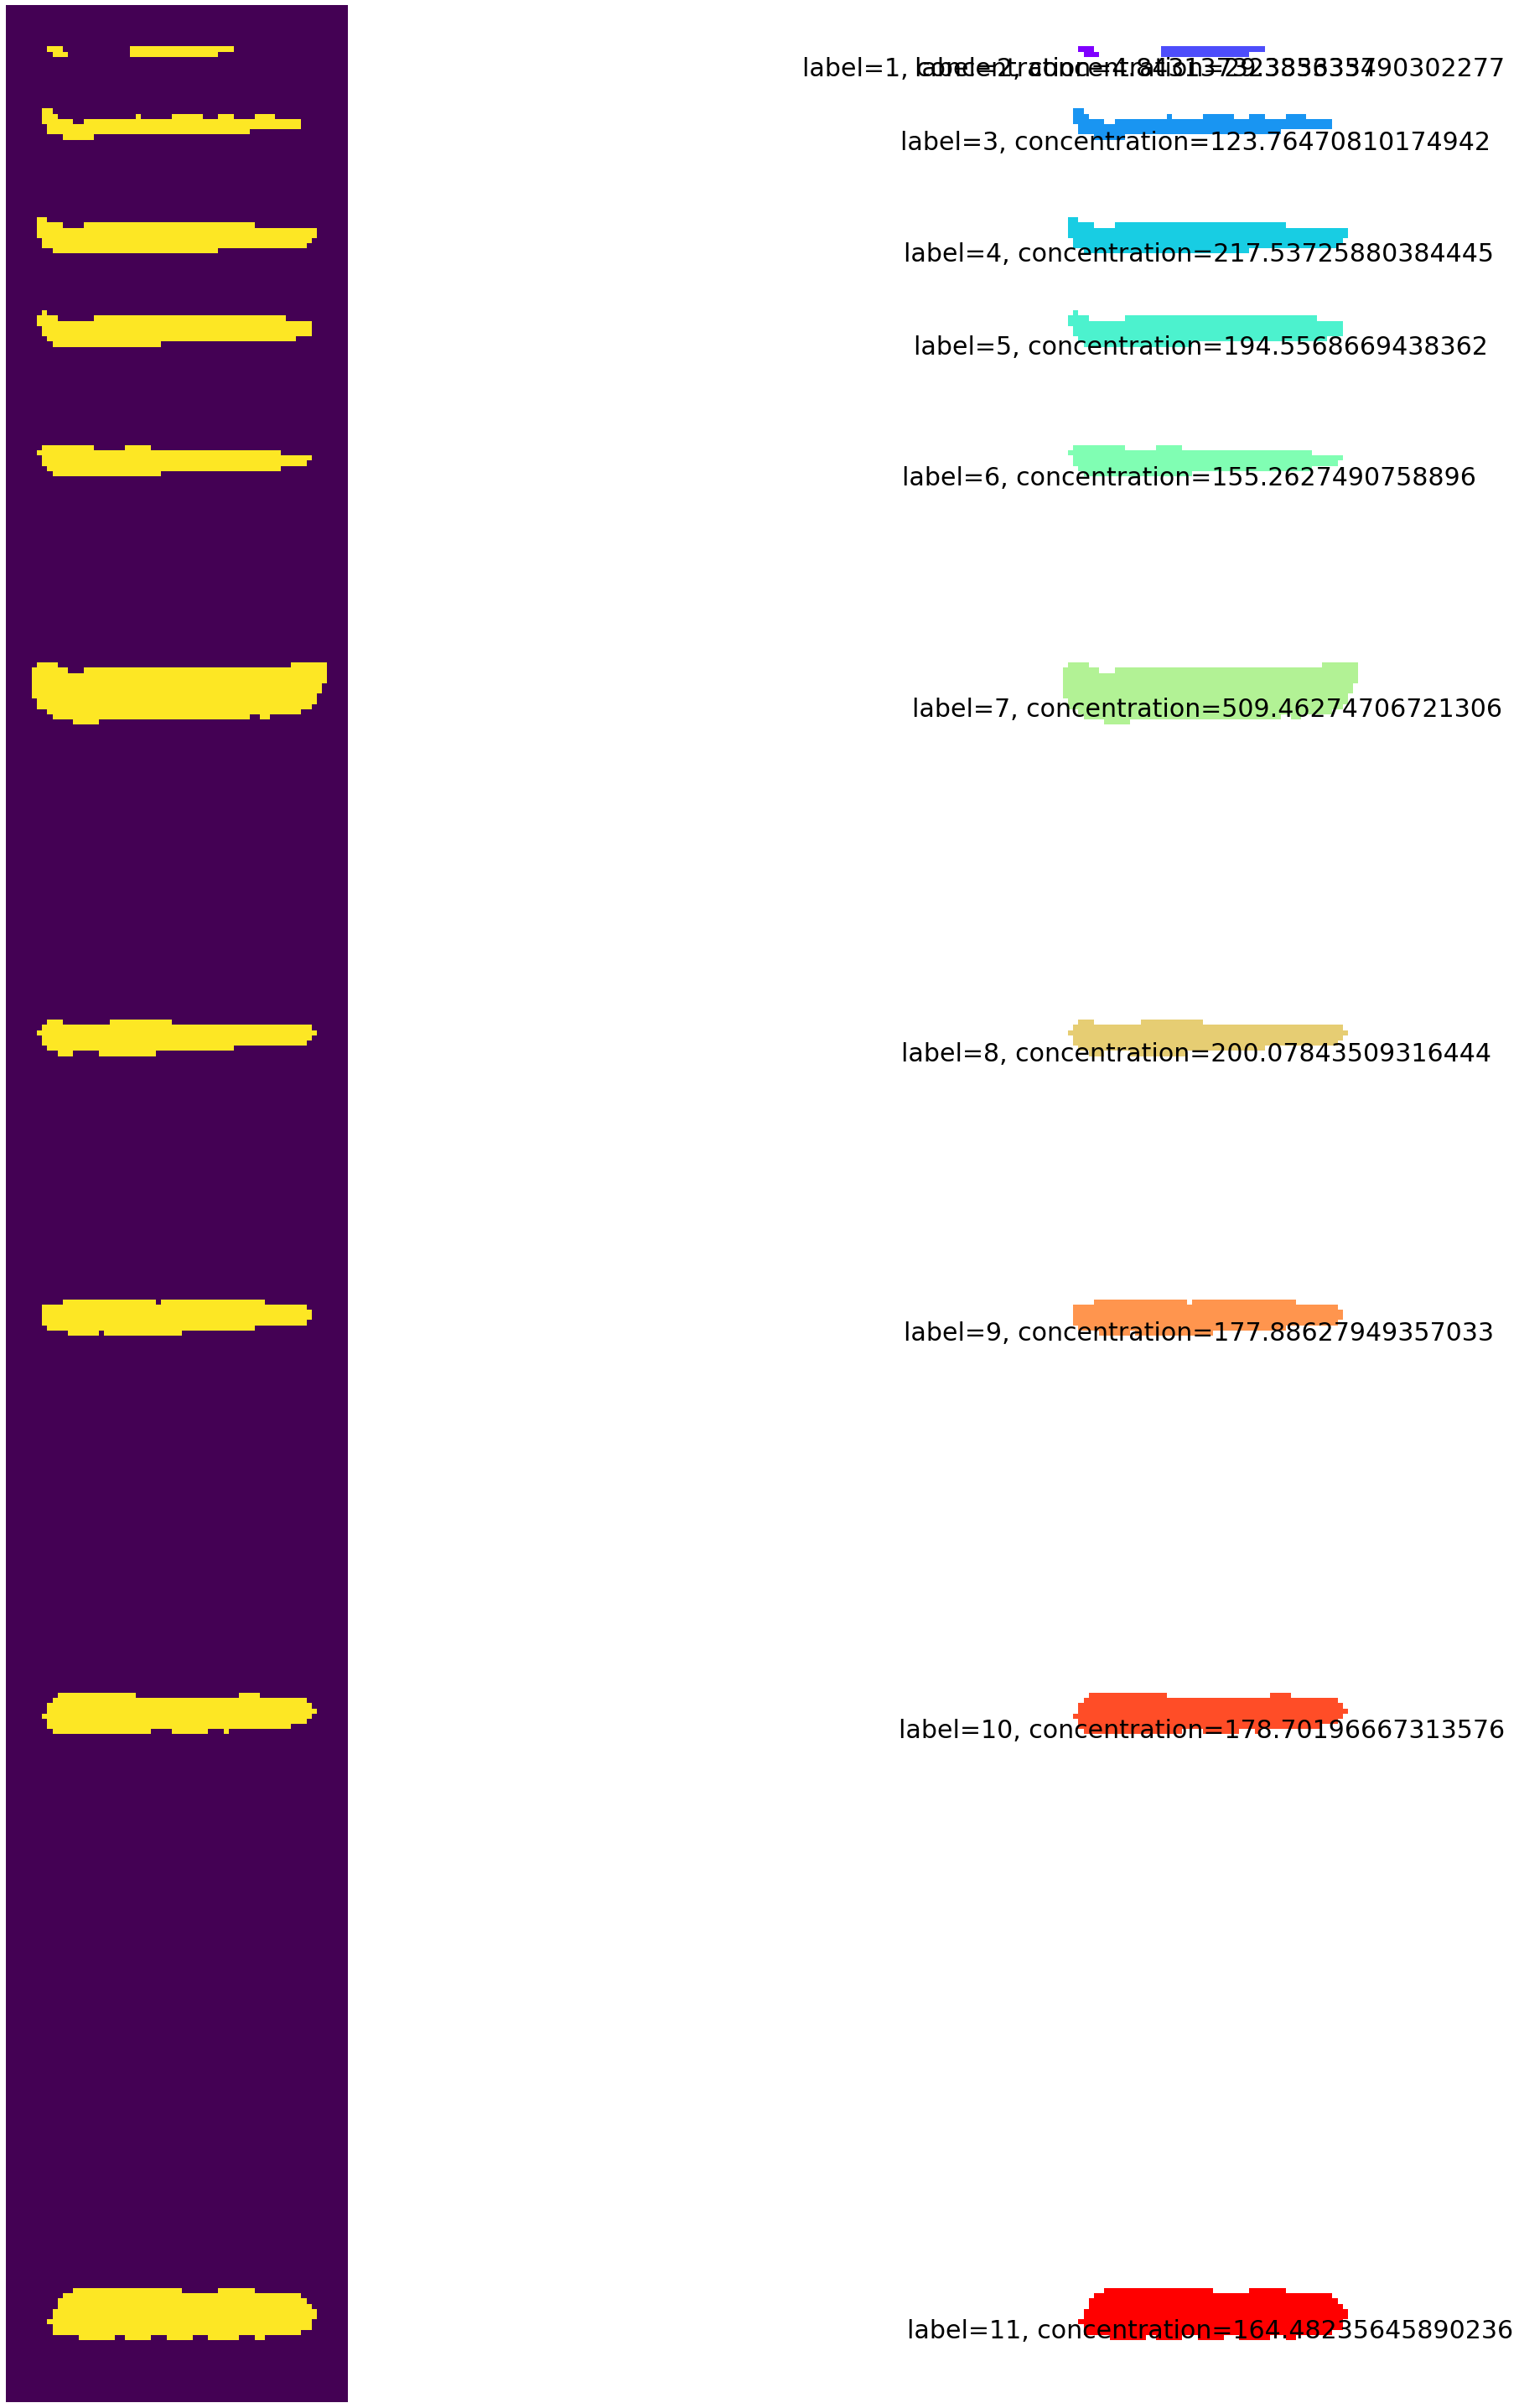

In [456]:
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt

# use a boolean condition to find where pixel values are > 0.75
blobs = thresholded == 1

# label connected regions that satisfy this condition
labels, nlabels = ndimage.label(blobs, structure=[[1,1,1],[1,1,1],[1,1,1]])


# find their centres of mass. in this case I'm weighting by the pixel values in
# `img`, but you could also pass the boolean values in `blobs` to compute the
# unweighted centroids.
r, c = np.vstack(ndimage.center_of_mass(thresholded, labels, np.arange(nlabels) + 1)).T

# find their distances from the top-left corner
d = np.sqrt(r*r + c*c)


# Get coordinates for each unique band
# create array of intensities
volume_labels = np.zeros((len(unique)), float)
area_labels = np.zeros((len(unique)), int)
print(volume_labels)
print(area_labels)

for h in range(height):
    for w in range(width):
        volume_labels[labels[h][w]] += original_image[h][w]  # index = label, value += intensity(between 0 and 1)
        area_labels[labels[h][w]] += 1
print(volume_labels)

# plot
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(40, 40))
ax[0].imshow(thresholded)
ax[1].imshow(np.ma.masked_array(labels, ~blobs), cmap=plt.cm.rainbow)
for ri, ci, di in zip(r, c, d):
#     ax[1].annotate('', xy=(0, 0), xytext=(ci, ri),
#                    arrowprops={'arrowstyle':'<-', 'shrinkA':0})
#     ax[1].annotate(f'label={label}, concentration={volume_labels[label]}', xy=(ci, ri),  xytext=(0, -5),
#     textcoords='offset points', ha='center', va='top',
    label = int(labels[int(ri)][int(ci)])
    ax[1].annotate(f'label={label}, concentration={volume_labels[label]}', xy=(ci, ri),  xytext=(0, -5),
               textcoords='offset points', ha='center', va='top',
               fontsize=30)
for aa in ax.flat:
    aa.set_axis_off()
fig.tight_layout()
plt.savefig('C:/Users/s2137314/Downloads/save as pdf3.pdf')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Real // Measured // GelAnalyzer
[[1.27272727 0.79354839 1.11282051]
 [1.51515152 1.4        1.44786325]
 [1.27272727 1.2516129  1.26666667]
 [1.         1.         1.        ]
 [3.78787879 3.28387097 3.22222222]
 [1.45454545 1.29032258 1.29401709]
 [1.09090909 1.14193548 0.96410256]
 [1.27272727 1.1483871  0.94017094]
 [1.27272727 1.05806452 0.80512821]]


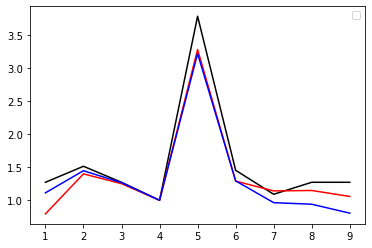

In [469]:
measured_ratios = []
real_ratios = []
analyzer_ratios = []
real_volumes = [42, 50, 42, 33, 125, 48, 36, 42, 42]
measured_volumes = [123, 217, 194, 155, 509, 200, 177, 178, 164]
analyzer_volumes = [651, 847, 741, 585, 1885, 757, 564, 550, 471]
base_value_real = 33
base_value_measured = 155
base_value_analyzer = 585

for r, m, a in zip(real_volumes, measured_volumes, analyzer_volumes):
    real_ratios.append(r/base_value_real)
    measured_ratios.append(m/base_value_measured)
    analyzer_ratios.append(a/base_value_analyzer)
print("Real // Measured // GelAnalyzer")
print(np.c_[real_ratios, measured_ratios, analyzer_ratios])
x = range(1,10)
plt.plot(x, real_ratios, color='black')
plt.plot(x, measured_ratios, color='red')
plt.plot(x, analyzer_ratios, color='blue')
plt.legend()




In [434]:
combi_mask_array = np.zeros((height, width, 3))  # np array [H, W, C]
for i in range(height):
    for j in range(width):
        if thresholded[i][j] == 1:
            combi_mask_array[i][j] = [1, 0, 0]
        else:  # Background
            if n_channels == 1:  # image_array [H,W] / grayscale
                combi_mask_array[i][j] = np.repeat(original_image[i][j], 3)  # Copies grayscale value to RGB channels
            elif n_channels == 3:  # image_array [H,W,C] / RGB
                combi_mask_array[i][j] = original_image[i][j]  # Copies RGB channel values all at once

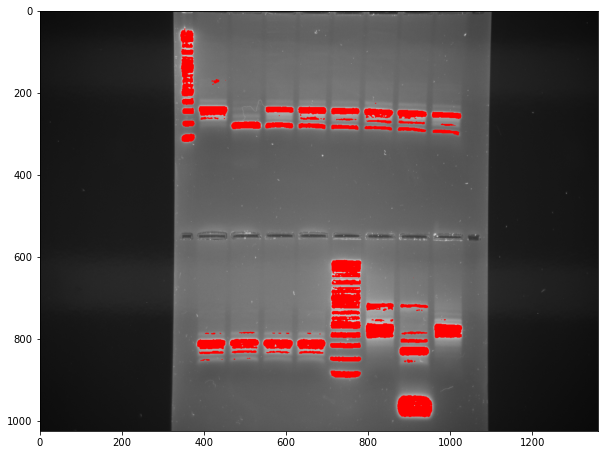

In [437]:
plt.figure(figsize=(10,15))
plt.imshow(combi_mask_array)
plt.savefig('C:/Users/s2137314/Downloads/superimpose.pdf')

In [342]:
for h in range(height):
    for w in range(width):
        volume_labels[labels[h][w]] += original_image[h][w]  # index = label, value += intensity(between 0 and 1)

IndexError: index 507 is out of bounds for axis 0 with size 507

<BarContainer object of 35 artists>

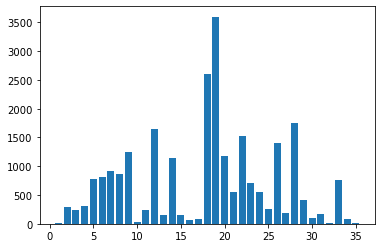

In [316]:
plt.bar(range(1, len(volume_labels)), volume_labels[1:])

In [264]:
volume_labels

array([5.45931443e+05, 1.18941179e+01, 2.60858831e+02, 1.08737257e+02,
       1.04552941e+02, 7.58517664e+02, 8.17364725e+02, 9.09611781e+02,
       8.70411786e+02, 1.01982356e+03, 1.65882358e+01, 1.30286278e+02,
       1.63955687e+03, 7.57451006e+01, 1.10182355e+03, 1.06003924e+02,
       3.10509813e+01, 3.56941181e+01, 2.53586670e+03, 2.90629413e+03,
       1.00343923e+03, 1.93756869e+02, 1.23213338e+03, 2.48756867e+02,
       3.47580403e+02, 9.33254933e+01, 1.26544710e+03, 6.58666680e+01,
       1.17376083e+03, 2.77933337e+02, 5.07725507e+01, 1.48756865e+02,
       1.36000001e+01, 7.39423540e+02, 2.96352942e+01, 1.25882356e+01])

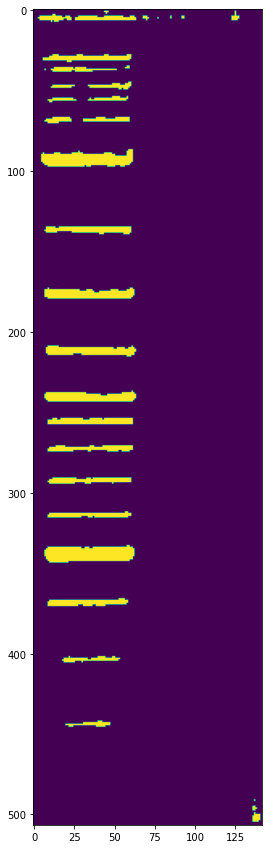

In [268]:
plt.figure(figsize=(10,15))
plt.imshow(thresholded)